In [42]:
# Imports
import pandas as pd
import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [6]:
# Loading the data
path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")

# Get the dimensions of images before we do anything to them
raw_dataset = datasets.ImageFolder(root=os.path.join(path, "data"))

sizes = []
for i in range(4000):  # Change this to scan more
    img_path, _ = raw_dataset.imgs[i]
    with Image.open(img_path) as img:
        sizes.append(img.size)  # (width, height)

unique_sizes = set(sizes)
print(f"Found {len(unique_sizes)} unique sizes:")
for size in unique_sizes:
    print(size)


Found 2 unique sizes:
(256, 256)
(64, 64)


In [7]:
# Load raw dataset without normalization
raw_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

raw_dataset = datasets.ImageFolder(root=os.path.join(path, "data"), transform=raw_transform)
class_names = raw_dataset.classes
print(f"Classes: {class_names}")
print(f"Total images: {len(raw_dataset)}")

Classes: ['cloudy', 'desert', 'green_area', 'water']
Total images: 5631


In [8]:
# Compute mean and std
loader = DataLoader(raw_dataset, batch_size=64, shuffle=False)

custom_mean = 0.
custom_std = 0.
total_images = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    custom_mean += images.mean(2).sum(0)
    custom_std += images.std(2).sum(0)
    total_images += batch_samples

custom_mean /= total_images
custom_std /= total_images

print("Computed mean:", custom_mean)
print("Computed std:", custom_std)
custom_mean = custom_mean.tolist()
custom_std = custom_std.tolist()

Computed mean: tensor([0.4002, 0.4314, 0.4275])
Computed std: tensor([0.0220, 0.0197, 0.0179])


In [9]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(custom_mean, custom_std),
])

# Transform for validation and test (no augmentation)
valid_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(custom_mean, custom_std),
])

In [10]:
# Load full dataset with no transform
full_dataset = datasets.ImageFolder(root=os.path.join(path, "data"), transform=None)

# Compute split sizes
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
torch.manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Assign appropriate transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = valid_transform
test_dataset.dataset.transform = valid_transform  # test uses same transform as val (NO augmentation)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


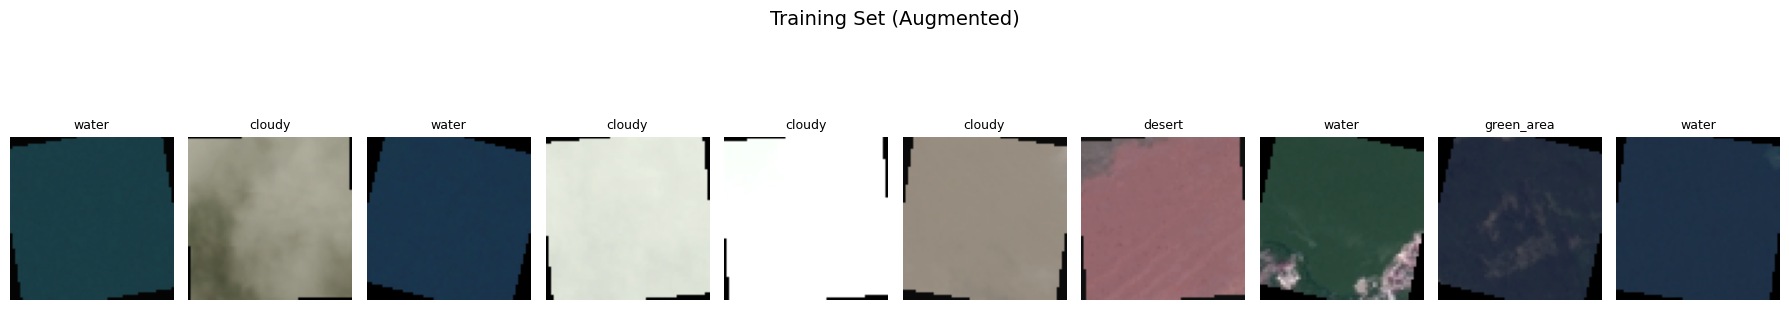

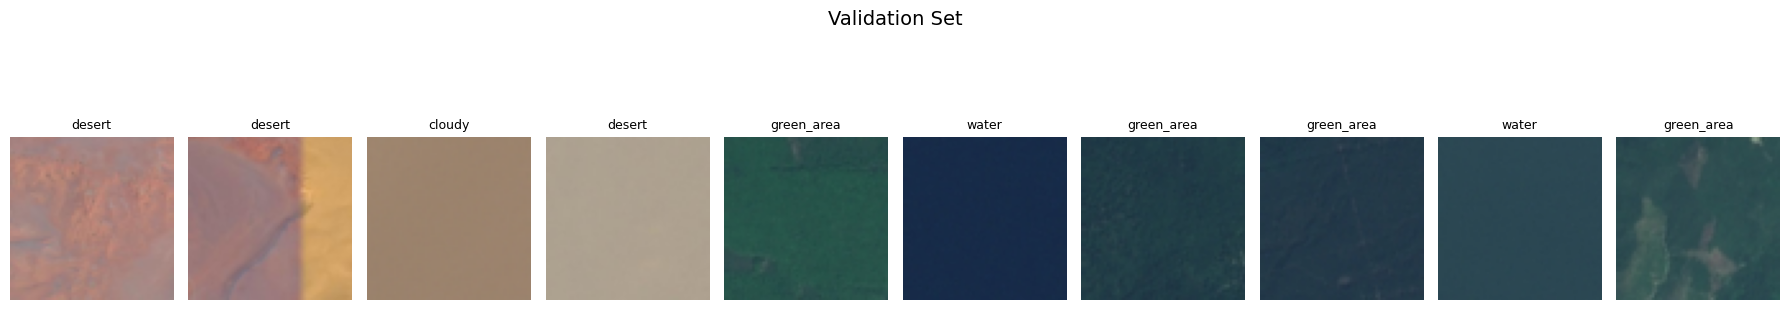

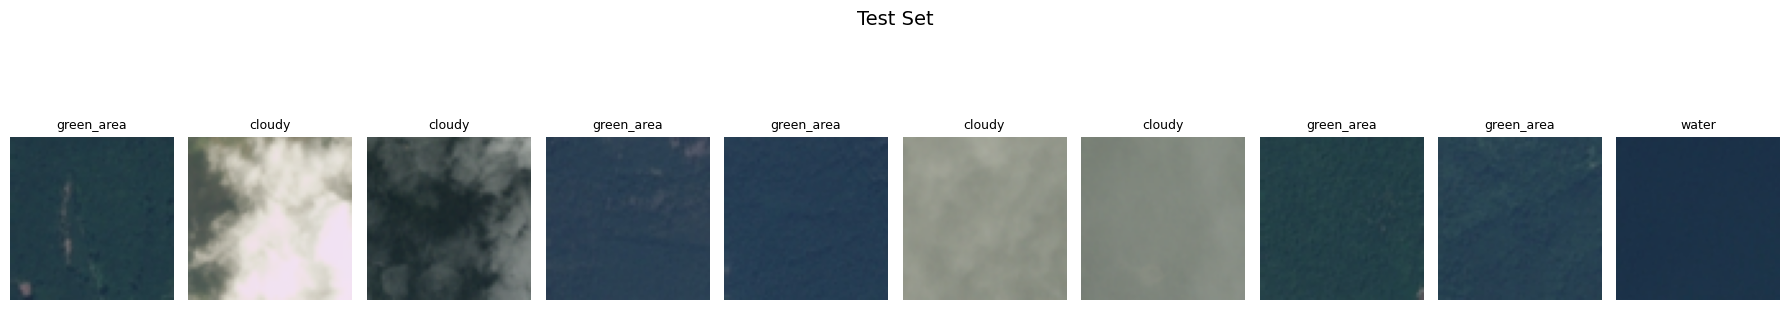

In [11]:
# Visualize some of the images in each set
def unnormalize(img_tensor):
    return img_tensor * torch.tensor(custom_std).view(3, 1, 1) + torch.tensor(custom_mean).view(3, 1, 1)

def show_random_images(dataset, transform, class_names, title, num_images=10):
    indices = torch.randperm(len(dataset))[:num_images]
    plt.figure(figsize=(18, 4))

    for i, idx in enumerate(indices):
        img_path, label = dataset.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if transform:
            image = transform(image)
            image = unnormalize(image)
        image = image.permute(1, 2, 0).numpy()

        plt.subplot(1, num_images, i + 1)
        plt.imshow(np.clip(image, 0, 1))
        plt.title(class_names[label], fontsize=9)
        plt.axis("off")
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Show 10 from each set
show_random_images(full_dataset, train_transform, full_dataset.classes, "Training Set (Augmented)", num_images=10)
show_random_images(full_dataset, valid_transform, full_dataset.classes, "Validation Set", num_images=10)
show_random_images(full_dataset, valid_transform, full_dataset.classes, "Test Set", num_images=10)


In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100.0 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = 100.0 * val_correct / val_total

        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")
        print(f"Val Loss:   {val_epoch_loss:.4f}, Val Acc:   {val_epoch_acc:.2f}%")
        print("-" * 50)

    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accuracies,
        "val_acc": val_accuracies
    }


In [13]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = test_loss / len(test_loader.dataset)
    accuracy = 100.0 * correct / total

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy

In [14]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [30]:
def plot_confusion_matrix_from_model(model, data_loader, class_names, device, title="Confusion Matrix"):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=False)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [60]:
# Create baseline model with nothing too special
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)
        
    def forward(self, x):
        # x = self.conv1(x)
        # x = self.relu(x)
        # x = self.pool(x)
        
        # x = self.conv2(x)
        # x = self.relu(x)
        # x = self.pool(x)
        
        # x = self.conv3(x)
        # x = self.relu(x)
        # x = self.pool(x)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        
        # x = self.fc1(x)
        # x = self.relu(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

num_classes = len(full_dataset.classes)

In [57]:
# Modify the simple model by adding drop out and global average pooling
class SimpleCNN_WithDropoutAndGAP(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN_WithDropoutAndGAP, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64, 256)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [17]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
simple_model = SimpleCNN(num_classes=num_classes)
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=1e-3)
# simple_optimizer = torch.optim.SGD(simple_model.parameters(), lr=0.01, momentum=0.9)
simple_history = train_model(
    model=simple_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=simple_optimizer,
    num_epochs=25,
    device=device
)

test_loss, test_acc = evaluate_model(simple_model, test_loader, criterion, device)

Epoch [1/25]
Train Loss: 0.4821, Train Acc: 77.98%
Val Loss:   0.3807, Val Acc:   83.65%
--------------------------------------------------
Epoch [2/25]
Train Loss: 0.3213, Train Acc: 87.24%
Val Loss:   0.8047, Val Acc:   76.90%
--------------------------------------------------
Epoch [3/25]
Train Loss: 0.2941, Train Acc: 87.95%
Val Loss:   0.2154, Val Acc:   89.57%
--------------------------------------------------
Epoch [4/25]
Train Loss: 0.2081, Train Acc: 91.70%
Val Loss:   0.1749, Val Acc:   93.25%
--------------------------------------------------
Epoch [5/25]
Train Loss: 0.1590, Train Acc: 93.94%
Val Loss:   0.1402, Val Acc:   95.14%
--------------------------------------------------
Epoch [6/25]
Train Loss: 0.1584, Train Acc: 94.44%
Val Loss:   0.2193, Val Acc:   92.77%
--------------------------------------------------
Epoch [7/25]
Train Loss: 0.1150, Train Acc: 96.42%
Val Loss:   0.1129, Val Acc:   97.27%
--------------------------------------------------
Epoch [8/25]
Train L

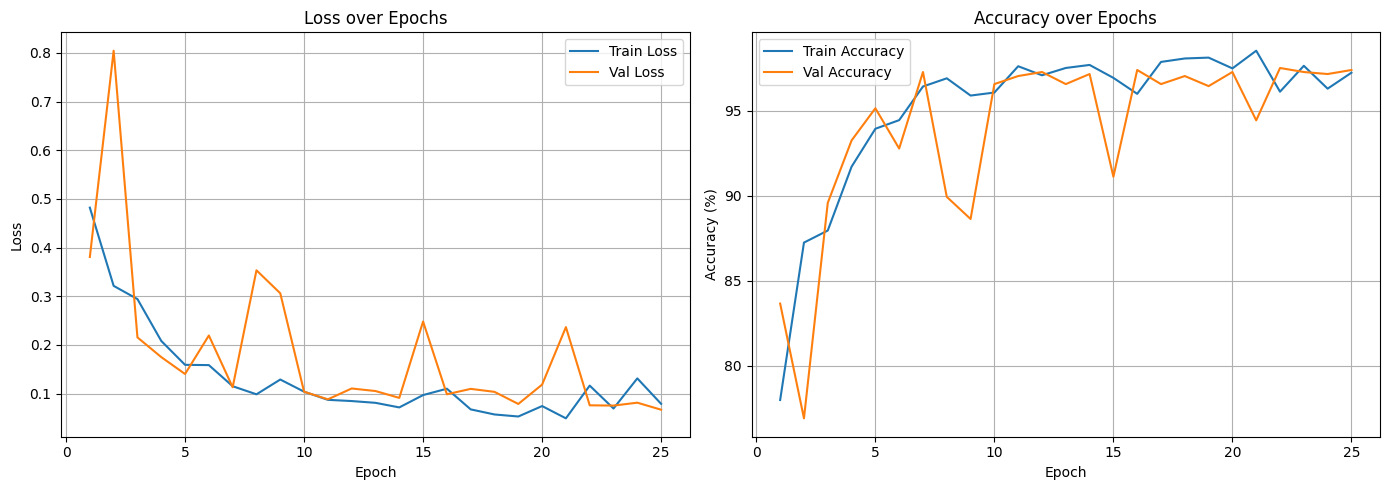

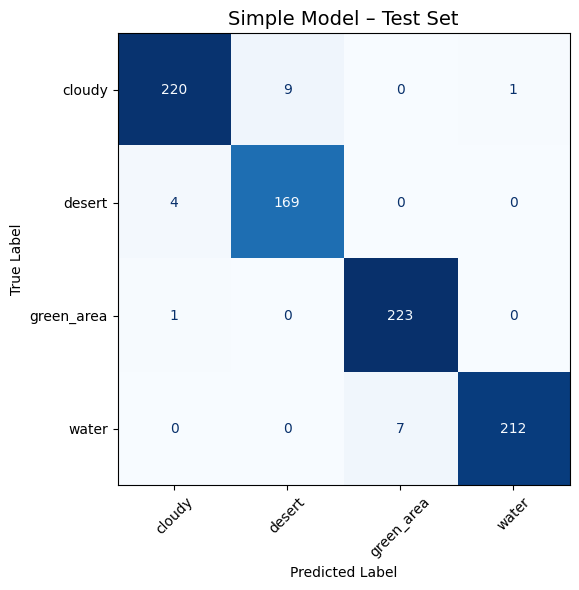

In [62]:
plot_training_history(simple_history)
plot_confusion_matrix_from_model(simple_model, test_loader, class_names, device, title="Simple Model – Test Set")


In [54]:
dropout_GAP_model = SimpleCNN_WithDropoutAndGAP(num_classes=num_classes)
dropout_GAP_optimizer = torch.optim.Adam(dropout_GAP_model.parameters(), lr=1e-3)
# dropout_GAP_optimizer = torch.optim.SGD(dropout_GAP_model.parameters(), lr=0.01, momentum=0.9)
dropout_GAP_history = train_model(
    model=dropout_GAP_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=dropout_GAP_optimizer,
    num_epochs=25,
    device=device
)

test_loss, test_acc = evaluate_model(dropout_GAP_model, test_loader, criterion, device)

Epoch [1/25]
Train Loss: 0.5826, Train Acc: 70.95%
Val Loss:   0.4495, Val Acc:   76.78%
--------------------------------------------------
Epoch [2/25]
Train Loss: 0.3902, Train Acc: 83.13%
Val Loss:   0.3134, Val Acc:   88.03%
--------------------------------------------------
Epoch [3/25]
Train Loss: 0.3201, Train Acc: 86.55%
Val Loss:   0.3162, Val Acc:   86.85%
--------------------------------------------------
Epoch [4/25]
Train Loss: 0.2757, Train Acc: 88.89%
Val Loss:   0.2274, Val Acc:   90.88%
--------------------------------------------------
Epoch [5/25]
Train Loss: 0.2418, Train Acc: 90.05%
Val Loss:   0.2132, Val Acc:   90.88%
--------------------------------------------------
Epoch [6/25]
Train Loss: 0.2013, Train Acc: 91.96%
Val Loss:   0.1840, Val Acc:   92.89%
--------------------------------------------------
Epoch [7/25]
Train Loss: 0.2086, Train Acc: 92.03%
Val Loss:   0.2693, Val Acc:   89.10%
--------------------------------------------------
Epoch [8/25]
Train L

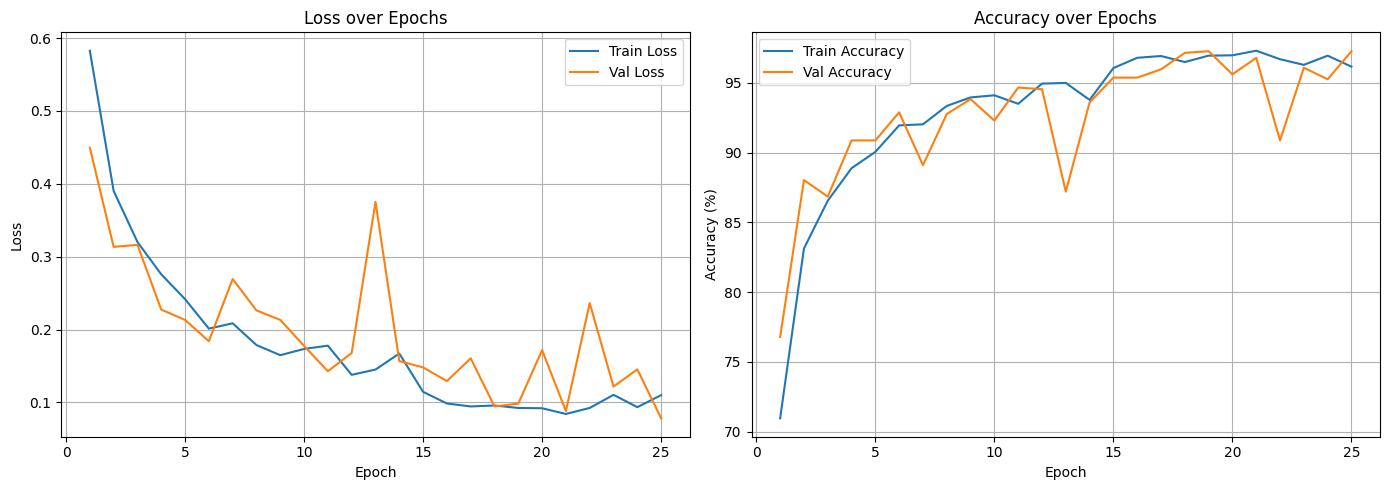

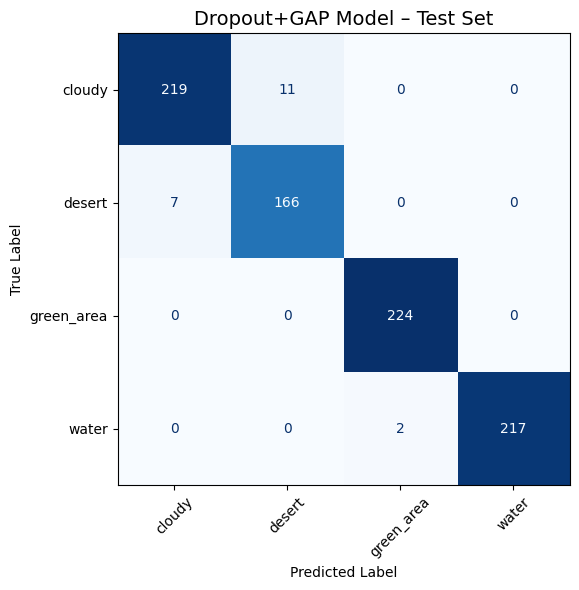

In [55]:
plot_training_history(dropout_GAP_history)
plot_confusion_matrix_from_model(dropout_GAP_model, test_loader, class_names, device, title="Dropout+GAP Model – Test Set")